# FINAL PROJECT: Gold-integrated Portfolio Optimization using Sharpe Ratio

**Course:** [MATH204] Introduction to Quantitative Finance  
**Semester:** Fall 2025  
**Instructor:** Le Tan  

## Group 2

**Team Members:**

- Vu Thi Khanh Ngoc  
- Nguyen Thi Thanh Mai  
- Ngo Nhi  
- Nguyen Le Na  
- Vi Thi Thu Ha  

---

## Project Description

This project focuses on **portfolio optimization** using the **Sharpe Ratio** as the performance metric. The goal is to determine the optimal allocation of a portfolio across three assets—Gold, Bonds, and Stocks—by maximizing the risk-adjusted return. 

We analyze historical monthly log returns of these assets from **2015 to 2025**, compute annualized mean returns and covariances, and apply **constrained optimization** to obtain optimal weights.

The results are visualized using **efficient frontiers** and **stacked bar charts** to illustrate the changing portfolio allocations over the years. This approach helps investors understand how risk and return trade-offs influence portfolio decisions in different market conditions.


In [ ]:
# Google Colab setup command to install PyPortfolioOpt
# !pip install git+https://github.com/robertmartin8/PyPortfolioOpt.git

  Cloning https://github.com/robertmartin8/PyPortfolioOpt.git to c:\users\hehe\appdata\local\temp\pip-req-build-n4960xes
  Installing build dependencies: started
  Installing build dependencies: finished with status 'error'


  Running command git clone -q https://github.com/robertmartin8/PyPortfolioOpt.git 'C:\Users\hehe\AppData\Local\Temp\pip-req-build-n4960xes'
  ERROR: Command errored out with exit status 1:
   command: 'c:\users\hehe\appdata\local\programs\python\python38\python.exe' 'c:\users\hehe\appdata\local\programs\python\python38\lib\site-packages\pip' install --ignore-installed --no-user --prefix 'C:\Users\hehe\AppData\Local\Temp\pip-build-env-sn7ij7hh\overlay' --no-warn-script-location --no-binary :none: --only-binary :none: -i https://pypi.org/simple -- 'setuptools>=78.1.1'
       cwd: None
  Complete output (4 lines):
  ERROR: Could not find a version that satisfies the requirement setuptools>=78.1.1 (from versions: 0.6b1, 0.6b2, 0.6b3, 0.6b4, 0.6rc1, 0.6rc2, 0.6rc3, 0.6rc4, 0.6rc5, 0.6rc6, 0.6rc7, 0.6rc8, 0.6rc9, 0.6rc10, 0.6rc11, 0.7.2, 0.7.3, 0.7.4, 0.7.5, 0.7.6, 0.7.7, 0.7.8, 0.8, 0.9, 0.9.1, 0.9.2, 0.9.3, 0.9.4, 0.9.5, 0.9.6, 0.9.7, 0.9.8, 1.0, 1.1, 1.1.1, 1.1.2, 1.1.3, 1.1.4, 1.1.5, 1.

In [1]:
# Import necessary libraries:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from pypfopt import EfficientFrontier, expected_returns, risk_models, plotting
from pypfopt.objective_functions import L2_reg
from pypfopt import EfficientFrontier, risk_models, expected_returns

## Data Preparation

### Merge into one DataFrame

In [2]:
# Read all dataset

# Google Colab file paths 
# bond = pd.read_csv("/content/bond_yield_daily.csv")
# stock = pd.read_csv("/content/stock_index_daily.csv")
# gold = pd.read_csv("/content/gold_prices_daily.csv")

# Local file paths
bond = pd.read_csv("data/bond_yield_daily.csv")
stock = pd.read_csv("data/stock_index_daily.csv")
gold = pd.read_csv("data/gold_prices_daily.csv")

In [3]:
# Check if there exists NaN values
print(bond.isna().sum())
print(stock.isna().sum())
print(gold.isna().sum())

Ngày          0
Lần cuối      0
Mở            0
Cao           0
Thấp          0
% Thay đổi    0
dtype: int64
Ngày          0
Lần cuối      0
Mở            0
Cao           0
Thấp          0
KL            0
% Thay đổi    0
dtype: int64
date              0
gold_price_vnd    0
dtype: int64


In [4]:
# Reverse the order
bond = bond.iloc[::-1].reset_index(drop=True)
stock = stock.iloc[::-1].reset_index(drop=True)

# Bond & Stock have date format: "01/10/2025" (day/month/year)
bond['date'] = pd.to_datetime(bond['Ngày'], format="%d/%m/%Y", errors='coerce')
stock['date'] = pd.to_datetime(stock['Ngày'], format="%d/%m/%Y", errors='coerce')

# Gold has format: "2025-08-15" (year-month-day)
gold['date'] = pd.to_datetime(gold['date'], format="%Y-%m-%d")

# Remove currency symbol and thousand separators
gold['gold_price_vnd'] = (
    gold['gold_price_vnd']
    .astype(str)
    .str.replace('₫', '', regex=False)
    .str.replace(',', '', regex=False)   # REMOVE COMMAS
    .str.strip()                         # remove any extra spaces
)

# Convert data values to numeric
bond['Lần cuối'] = pd.to_numeric(bond['Lần cuối'].astype(str).str.replace(',', '').str.strip(), errors='coerce')
stock['Lần cuối'] = pd.to_numeric(stock['Lần cuối'].astype(str).str.replace(',', '').str.strip(), errors='coerce')
gold['gold_price_vnd'] = pd.to_numeric(gold['gold_price_vnd'], errors='coerce')

In [5]:
gold['date'] = pd.to_datetime(gold['date'])
bond['date'] = pd.to_datetime(bond['date'])
stock['date'] = pd.to_datetime(stock['date'])

gold = gold.sort_values("date")
gold["month_year"] = gold["date"].dt.to_period("M")

# Fetch the last entry for each month
gold_last = (
    gold.groupby("month_year")
        .tail(1)[["month_year", "gold_price_vnd"]]
        .reset_index(drop=True)
)

bond = bond.sort_values("date")
bond["month_year"] = bond["date"].dt.to_period("M")

bond_last = (
    bond.groupby("month_year")
        .tail(1)[["month_year", "Lần cuối"]]
        .rename(columns={"Lần cuối": "bond_yield"})
        .reset_index(drop=True)
)

stock = stock.sort_values("date")
stock["month_year"] = stock["date"].dt.to_period("M")

stock_last = (
    stock.groupby("month_year")
        .tail(1)[["month_year", "Lần cuối"]]
        .rename(columns={"Lần cuối": "stock_index"})
        .reset_index(drop=True)
)

# Merge datasets on month_year
df = (
    gold_last
    .merge(bond_last, on="month_year", how="inner")
    .merge(stock_last, on="month_year", how="inner")
)

df["month_year"] = df["month_year"].astype(str)

# df = df.iloc[:-1]

df

,month_year,gold_price_vnd,bond_yield,stock_index
0,2015-10,25515650.0,7.062,607.37
1,2015-11,23967860.0,7.060,573.20
2,2015-12,23846470.0,7.052,579.03
3,2016-01,24848700.0,7.037,545.25
4,2016-02,27664260.0,6.863,559.37
...,...,...,...,...
116,2025-06,86272600.0,3.335,1376.07
117,2025-07,86198000.0,3.448,1502.52
118,2025-08,90842700.0,3.689,1682.21
119,2025-09,101969000.0,3.761,1661.70


### Take log return of monthly asset price

Log returns are computed using:

$$
\ln\left(\frac{P_t}{P_{t-1}}\right)
$$

Where:
- $P_t$ is the price at time $t$
- $P_{t-1}$ is the price in the previous period


In [7]:
df_returns = df.copy()

# Compute log returns
df_returns['gold_log_return'] = np.log(df_returns['gold_price_vnd'] / df_returns['gold_price_vnd'].shift(1))
df_returns['bond_log_return'] = np.log(df_returns['bond_yield'] / df_returns['bond_yield'].shift(1))
df_returns['stock_log_return'] = np.log(df_returns['stock_index'] / df_returns['stock_index'].shift(1))

# Drop the first row (NaN from shift)
df_returns = df_returns.dropna().reset_index(drop=True)

print(df_returns.tail())

    month_year  gold_price_vnd  bond_yield  stock_index  gold_log_return  \
115    2025-06      86272600.0       3.335      1376.07         0.007830   
116    2025-07      86198000.0       3.448      1502.52        -0.000865   
117    2025-08      90842700.0       3.689      1682.21         0.052482   
118    2025-09     101969000.0       3.761      1661.70         0.115539   
119    2025-10     105331000.0       3.954      1671.07         0.032439   

     bond_log_return  stock_log_return  
115         0.035091          0.032100  
116         0.033322          0.087912  
117         0.067561          0.112965  
118         0.019329         -0.012267  
119         0.050043          0.005623  


### Annualize


$$
\text{Annualized Mean Return} = \text{Mean Monthly Return} \times 12
$$


$$
\text{Annual Covariance} = \text{Monthly Covariance} \times 12
$$


$$
\text{Annual Standard Deviation} = \text{Monthly Standard Deviation} \times \sqrt{12}
$$


In [8]:
# Select log return columns
returns = df_returns[['gold_log_return', 'bond_log_return', 'stock_log_return']]

# Annualize mean return vector
mean_return_annual = returns.mean() * 12

# Annualize covariance matrix
cov_matrix_annual = returns.cov() * 12

# Annualize
std_annual = returns.std() * np.sqrt(12)

print("Annualized Mean Return Vector:")
print(mean_return_annual)

print("\nAnnualized Covariance Matrix:")
print(cov_matrix_annual)

print("\nAnnualized Standard Deviation:")
print(std_annual)


Annualized Mean Return Vector:
gold_log_return     0.141782
bond_log_return    -0.058000
stock_log_return    0.101208
dtype: float64

Annualized Covariance Matrix:
                  gold_log_return  bond_log_return  stock_log_return
gold_log_return          0.018520        -0.002035          0.001067
bond_log_return         -0.002035         0.061413         -0.022849
stock_log_return         0.001067        -0.022849          0.042497

Annualized Standard Deviation:
gold_log_return     0.136089
bond_log_return     0.247816
stock_log_return    0.206147
dtype: float64


# QUESTION 1: Which types of assets have the highest Sharpe ratio in Vietnam?

$$
\text{Sharpe Ratio} = \frac{\mu_{\text{annual}} - R_f}{\sigma_{\text{annual}}},
\quad \text{where}
\quad
\begin{aligned}
\mu_{\text{annual}} &= \text{annualized mean log return} = \text{mean of monthly log returns} \times 12, \\
\sigma_{\text{annual}} &= \text{annualized standard deviation of log returns} = \text{standard deviation of monthly log returns} \times \sqrt{12}, \\
R_f &= \text{annual risk-free rate}.
\end{aligned}
$$


In [33]:
# Risk-free rate
rf_annual = 0.04

# Sharpe ratio
sharpe_annual = (mean_return_annual - rf_annual) / std_annual

# Build table
stats_table = pd.DataFrame({
    "Gold": [mean_return_annual["gold_log_return"], std_annual["gold_log_return"], sharpe_annual["gold_log_return"]],
    "Bond": [mean_return_annual["bond_log_return"], std_annual["bond_log_return"], sharpe_annual["bond_log_return"]],
    "Stock": [mean_return_annual["stock_log_return"], std_annual["stock_log_return"], sharpe_annual["stock_log_return"]],
},
index=["Mean p.a.", "SD p.a.", "Sharpe ratio p.a."]
)

stats_table

,Gold,Bond,Stock
Mean p.a.,0.141782,-0.058000,0.101208
SD p.a.,0.136089,0.247816,0.206147
Sharpe ratio p.a.,0.747903,-0.395455,0.296915


In [10]:
# Risk-free rate
rf_annual = 0.04

# Sharpe ratio
sharpe_annual = (mean_return_annual - rf_annual) / std_annual

# Composite portfolios
# Portfolio 1: Gold + Bond + Stock (equal-weight example)
w_gbs = np.array([1/3, 1/3, 1/3])

# Portfolio 2: Bond + Stock (equal-weight example)
w_bs = np.array([0, 0.5, 0.5])

# Compute composite returns
mean_gbs = w_gbs @ mean_return_annual.values
std_gbs = np.sqrt(w_gbs @ cov_matrix_annual.values @ w_gbs)
sharpe_gbs = (mean_gbs - rf_annual) / std_gbs

mean_bs = w_bs @ mean_return_annual.values
std_bs = np.sqrt(w_bs @ cov_matrix_annual.values @ w_bs)
sharpe_bs = (mean_bs - rf_annual) / std_bs

# Build table
stats_table = pd.DataFrame({
    "Gold":  [mean_return_annual["gold_log_return"],  std_annual["gold_log_return"],  sharpe_annual["gold_log_return"]],
    "Bond":  [mean_return_annual["bond_log_return"],  std_annual["bond_log_return"],  sharpe_annual["bond_log_return"]],
    "Stock": [mean_return_annual["stock_log_return"], std_annual["stock_log_return"], sharpe_annual["stock_log_return"]],
    "GBS (with Gold)": [mean_gbs, std_gbs, sharpe_gbs],
    "BS (no Gold)":    [mean_bs,  std_bs,  sharpe_bs]
},
index=["Mean p.a.", "SD p.a.", "Sharpe ratio p.a."]
)

stats_table


,Gold,Bond,Stock,GBS (with Gold),BS (no Gold)
Mean p.a.,0.141782,-0.058000,0.101208,0.061663,0.021604
SD p.a.,0.136089,0.247816,0.206147,0.091163,0.120635
Sharpe ratio p.a.,0.747903,-0.395455,0.296915,0.237633,-0.152492


## QUESTION 2: Efficient frontiers 




**Objective:** Maximize the Sharpe ratio of a portfolio including the risk-free rate $R_f$:

$$
\max_{w} \text{Sharpe Ratio}(w) = \frac{w^T \mu - R_f}{\sqrt{w^T \Sigma w}}
$$


Source: https://bookdown.org/palomar/portfoliooptimizationbook/7.2-MSRP.html


**Where:**  
- $w = [w_1, w_2, \dots, w_n]^T$ is the vector of portfolio weights  
- $\mu = [\mu_1, \mu_2, \dots, \mu_n]^T$ is the vector of expected annual returns of the assets  
- $\Sigma$ is the covariance matrix of asset returns  
- $R_f$ is the annual risk-free rate  

**Constraints:**  
1. Portfolio weights sum to 1:  
$$
\sum_{i=1}^{n} w_i = 1
$$  
2. Long-only portfolio (no short selling):  
$$
0 \le w_i \le 1, \quad i = 1, \dots, n
$$




*   Gold_min = 5%
*   Bond_max = 30%

In [34]:
# mean return vector and covariance matrix from your data
mu = mean_return_annual.values        # array of expected returns
Sigma = cov_matrix_annual.values      # covariance matrix

Expected annual return: 12.4%
Annual volatility: 11.0%
Sharpe Ratio: 0.76
Expected annual return: 13.4%
Annual volatility: 11.8%
Sharpe Ratio: 0.79


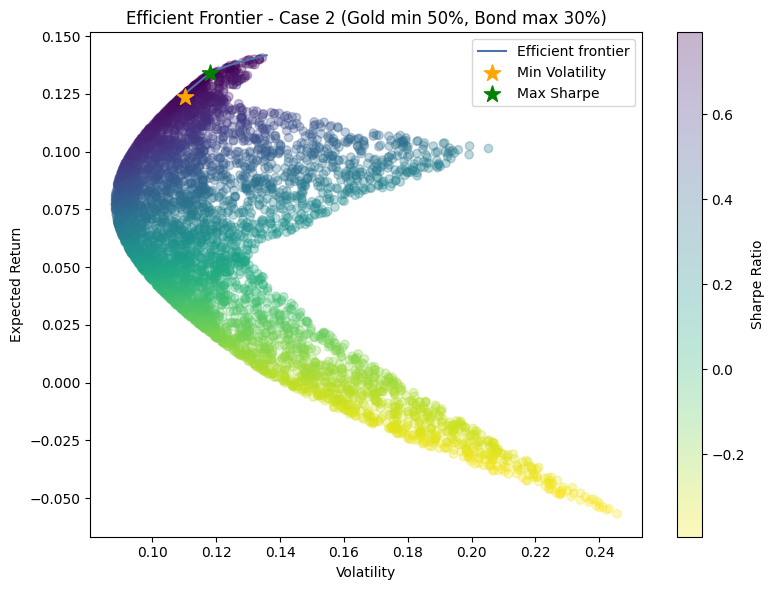

In [35]:

ef_case2 = EfficientFrontier(mu, Sigma, weight_bounds=(0,1))
ef_case2.add_constraint(lambda w: w[0] >= 0.05)  # Gold >= 5%
ef_case2.add_constraint(lambda w: w[1] <= 0.03)  # Bond <= 30%

# Minimum volatility
ef_min_vol_case2 = ef_case2.deepcopy()
weights_min_vol_case2 = ef_min_vol_case2.min_volatility()
ret_min_vol2, std_min_vol2, _ = ef_min_vol_case2.portfolio_performance(risk_free_rate=rf_annual, verbose=True)

# Maximum Sharpe ratio
ef_max_sharpe_case2 = ef_case2.deepcopy()
weights_max_sharpe_case2 = ef_max_sharpe_case2.max_sharpe(risk_free_rate=0.04)
ret_max_sharpe2, std_max_sharpe2, _ = ef_max_sharpe_case2.portfolio_performance(risk_free_rate=rf_annual, verbose=True)

fig2, ax2 = plt.subplots(figsize=(8,6))
plotting.plot_efficient_frontier(ef_case2, ax=ax2, show_assets=False)

# Highlight portfolios
ax2.scatter(std_min_vol2, ret_min_vol2, marker="*", s=150, c="orange", label="Min Volatility", zorder=10)
ax2.scatter(std_max_sharpe2, ret_max_sharpe2, marker="*", s=150, c="green", label="Max Sharpe", zorder=10)

# Random portfolios
n_samples = 5000
w_random = np.random.dirichlet(np.ones(len(mu)), n_samples)
rets_random = w_random.dot(mu)
stds_random = np.sqrt(np.einsum('ij,jk,ik->i', w_random, Sigma, w_random))
sharpes_random = (rets_random - rf_annual) / stds_random
sc2 = ax2.scatter(stds_random, rets_random, c=sharpes_random, cmap="viridis_r", alpha=0.3)
cbar2 = plt.colorbar(sc2, ax=ax2)
cbar2.set_label("Sharpe Ratio")
ax2.set_xlabel("Volatility")
ax2.set_ylabel("Expected Return")
ax2.set_title("Efficient Frontier - Case 2 (Gold min 50%, Bond max 30%)")
ax2.legend()
plt.tight_layout()
plt.show()

Expected annual return: 13.5%
Annual volatility: 12.9%
Sharpe Ratio: 0.74
Expected annual return: 14.0%
Annual volatility: 13.0%
Sharpe Ratio: 0.77


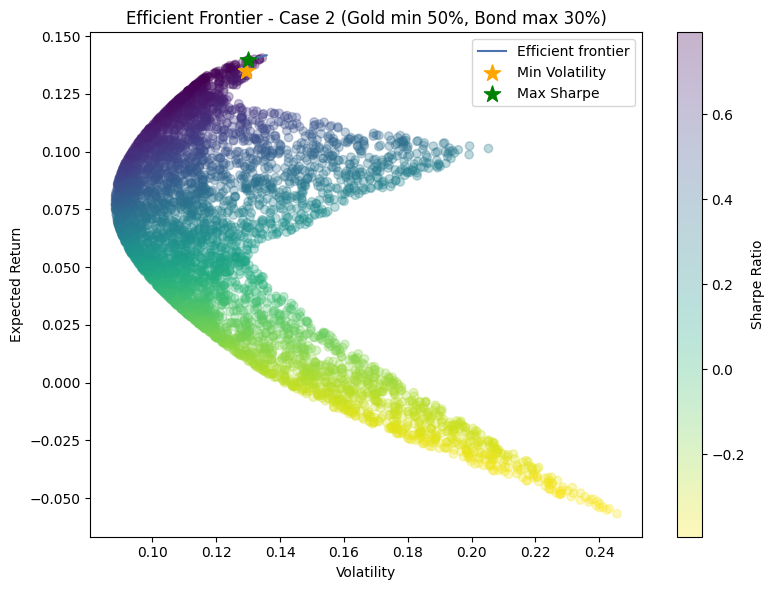

In [36]:

ef_case2 = EfficientFrontier(mu, Sigma, weight_bounds=(0,1))
ef_case2.add_constraint(lambda w: w[0] >= 0.95)  # Gold >= 5%
ef_case2.add_constraint(lambda w: w[1] <= 0.03)  # Bond <= 30%

# Minimum volatility
ef_min_vol_case2 = ef_case2.deepcopy()
weights_min_vol_case2 = ef_min_vol_case2.min_volatility()
ret_min_vol2, std_min_vol2, _ = ef_min_vol_case2.portfolio_performance(risk_free_rate=rf_annual, verbose=True)

# Maximum Sharpe ratio
ef_max_sharpe_case2 = ef_case2.deepcopy()
weights_max_sharpe_case2 = ef_max_sharpe_case2.max_sharpe(risk_free_rate=0.04)
ret_max_sharpe2, std_max_sharpe2, _ = ef_max_sharpe_case2.portfolio_performance(risk_free_rate=rf_annual, verbose=True)

fig2, ax2 = plt.subplots(figsize=(8,6))
plotting.plot_efficient_frontier(ef_case2, ax=ax2, show_assets=False)

# Highlight portfolios
ax2.scatter(std_min_vol2, ret_min_vol2, marker="*", s=150, c="orange", label="Min Volatility", zorder=10)
ax2.scatter(std_max_sharpe2, ret_max_sharpe2, marker="*", s=150, c="green", label="Max Sharpe", zorder=10)

# Random portfolios
sc2 = ax2.scatter(stds_random, rets_random, c=sharpes_random, cmap="viridis_r", alpha=0.3)
cbar2 = plt.colorbar(sc2, ax=ax2)
cbar2.set_label("Sharpe Ratio")
ax2.set_xlabel("Volatility")
ax2.set_ylabel("Expected Return")
ax2.set_title("Efficient Frontier - Case 2 (Gold min 50%, Bond max 30%)")
ax2.legend()
plt.tight_layout()
plt.show()

Expected annual return: 5.4%
Annual volatility: 10.2%
Sharpe Ratio: 0.14
Expected annual return: 5.8%
Annual volatility: 11.1%
Sharpe Ratio: 0.16


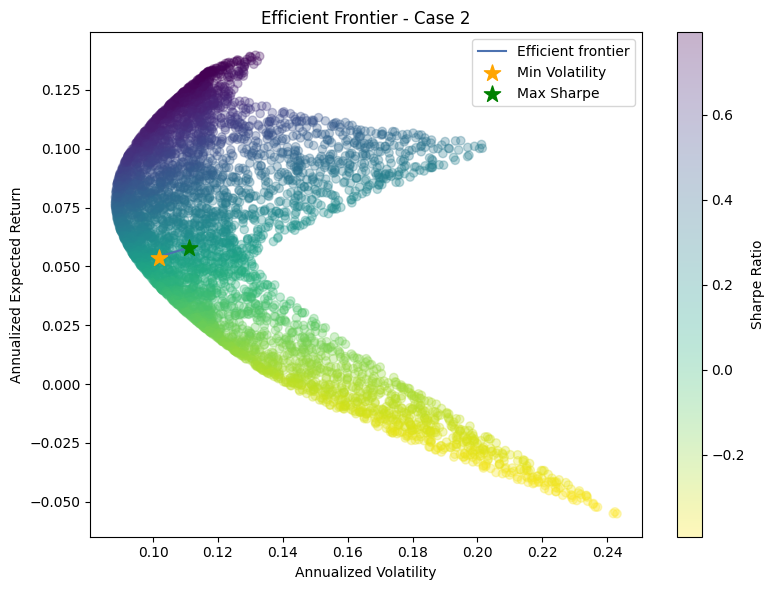

In [37]:

ef_case2 = EfficientFrontier(mu, Sigma, weight_bounds=(0,1))
ef_case2.add_constraint(lambda w: w[0] <= 0.50)  # Gold <= 50%
ef_case2.add_constraint(lambda w: w[1] >= 0.40)  # Bond >= 40%
ef_case2.add_constraint(lambda w: w[2] <= 0.20)  # Stock <= 20%
# -----------------------------
# Minimum Volatility Portfolio
# -----------------------------
ef_min_vol_case2 = ef_case2.deepcopy()
weights_min_vol_case2 = ef_min_vol_case2.min_volatility()
ret_min_vol2, std_min_vol2, sharpe_min_vol2 = ef_min_vol_case2.portfolio_performance(
    risk_free_rate=rf_annual, verbose=True
)

# -----------------------------
# Maximum Sharpe Ratio Portfolio
# -----------------------------
ef_max_sharpe_case2 = ef_case2.deepcopy()
weights_max_sharpe_case2 = ef_max_sharpe_case2.max_sharpe(risk_free_rate=rf_annual)
ret_max_sharpe2, std_max_sharpe2, sharpe_max_sharpe2 = ef_max_sharpe_case2.portfolio_performance(
    risk_free_rate=rf_annual, verbose=True
)

# -----------------------------
# Plot Efficient Frontier
# -----------------------------
fig, ax = plt.subplots(figsize=(8,6))
plotting.plot_efficient_frontier(ef_case2, ax=ax, show_assets=False)

# Highlight minimum volatility and max Sharpe portfolios
ax.scatter(std_min_vol2, ret_min_vol2, marker="*", s=150, c="orange", label="Min Volatility", zorder=10 )
ax.scatter(std_max_sharpe2, ret_max_sharpe2, marker="*", s=150, c="green", label="Max Sharpe", zorder=10 )

# Random portfolios for reference
n_samples = 5000
w_random = np.random.dirichlet(np.ones(len(mu)), n_samples)
rets_random = w_random.dot(mu)
stds_random = np.sqrt(np.einsum('ij,jk,ik->i', w_random, Sigma, w_random))
sharpes_random = (rets_random - rf_annual) / stds_random
sc = ax.scatter(stds_random, rets_random, c=sharpes_random, cmap="viridis_r", alpha=0.3)

cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("Sharpe Ratio")
ax.set_xlabel("Annualized Volatility")
ax.set_ylabel("Annualized Expected Return")
ax.set_title("Efficient Frontier - Case 2")
ax.legend()
plt.tight_layout()
plt.show()

## QUESTION 3: Optimal weight: Static Sharpe Ratio

In [43]:
df_returns

,month_year,gold_price_vnd,bond_yield,stock_index,gold_log_return,bond_log_return,stock_log_return
0,2015-11,23967860.0,7.060,573.20,-0.062578,-0.000283,-0.057903
1,2015-12,23846470.0,7.052,579.03,-0.005078,-0.001134,0.010120
2,2016-01,24848700.0,7.037,545.25,0.041169,-0.002129,-0.060110
3,2016-02,27664260.0,6.863,559.37,0.107336,-0.025037,0.025567
4,2016-03,27480590.0,6.868,561.22,-0.006661,0.000728,0.003302
...,...,...,...,...,...,...,...
115,2025-06,86272600.0,3.335,1376.07,0.007830,0.035091,0.032100
116,2025-07,86198000.0,3.448,1502.52,-0.000865,0.033322,0.087912
117,2025-08,90842700.0,3.689,1682.21,0.052482,0.067561,0.112965
118,2025-09,101969000.0,3.761,1661.70,0.115539,0.019329,-0.012267


Optimal Weights by Year:


c:\Users\hehe\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\optimize\_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


,Gold,Bond,Stock
2015,0.050000,0.000000e+00,9.500000e-01
2016,0.086347,0.000000e+00,9.136532e-01
2017,0.422101,0.000000e+00,5.778990e-01
2018,0.050000,1.387779e-16,9.500000e-01
2019,0.565994,1.337527e-15,4.340064e-01
2020,0.924021,5.316385e-16,7.597939e-02
2021,0.050000,8.326673e-16,9.500000e-01
2022,0.700000,3.000000e-01,5.867529e-14
2023,0.875493,0.000000e+00,1.245067e-01
2024,0.517813,2.408110e-01,2.413757e-01


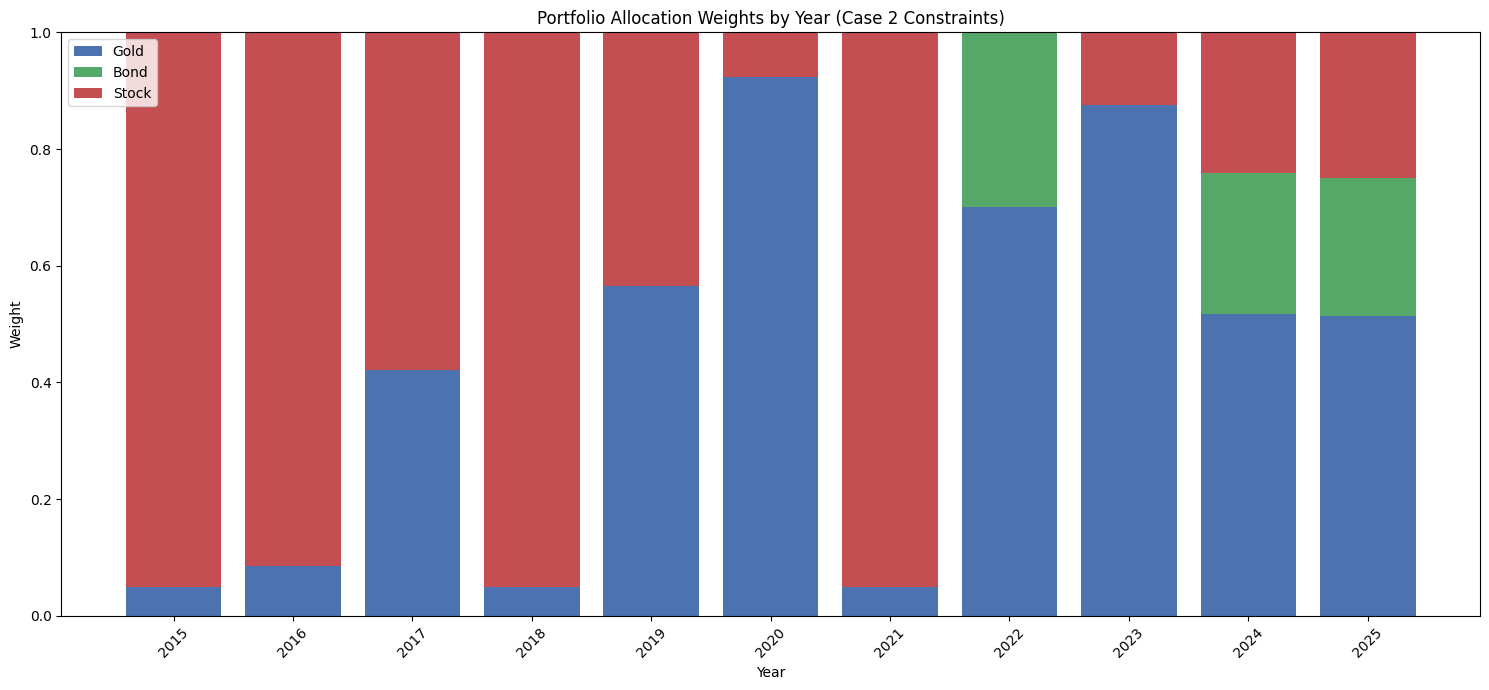

In [46]:


# ============================================================
# 1. PREPARE DATA
# ============================================================

# Make sure month_year is datetime
df_returns['month_year'] = pd.to_datetime(df_returns['month_year'], format='%Y-%m')


# Asset names
assets = ['Gold', 'Bond', 'Stock']
n = 3

# Index for constraints
idx_gold = 0
idx_bond = 1

# ============================================================
# 2. OPTIMIZATION FUNCTION (CASE 2)
# ============================================================

def neg_sharpe(w, mu, Sigma):
    return - (w @ mu - rf_annual) / np.sqrt(w @ Sigma @ w)

def optimize_weights(mu, Sigma):
    
    # Constraints
    cons = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]    
    
    # Bounds
    bounds = [(0,1)] * n
    bounds[idx_gold] = (0.05, 1)   # Gold ≥ 5%
    bounds[idx_bond] = (0, 0.30)   # Bond ≤ 30%

    # Initial guess
    w0 = np.array([0.33, 0.33, 0.34])
    w0[idx_gold] = max(w0[idx_gold], 0.05)
    w0[idx_bond] = min(w0[idx_bond], 0.30)
    w0 = w0 / np.sum(w0)

    result = minimize(
        neg_sharpe, w0, args=(mu, Sigma),
        method='SLSQP', bounds=bounds, constraints=cons
    )
    
    return result.x


# ============================================================
# 3. LOOP YEAR-BY-YEAR AND COMPUTE OPTIMAL WEIGHTS
# ============================================================

weights_by_year = {}

for year in range(2015, 2026):

    yearly_data = df_returns[df_returns['month_year'].dt.year == year]

    if len(yearly_data) == 0:
        continue

    # Use your log-return columns
    mu = yearly_data[['gold_log_return','bond_log_return','stock_log_return']].mean() * 12
    Sigma = yearly_data[['gold_log_return','bond_log_return','stock_log_return']].cov() * 12

    # Optimize
    w_opt = optimize_weights(mu.values, Sigma.values)
    weights_by_year[year] = w_opt


# Convert to DataFrame for plotting
weights_df = pd.DataFrame(weights_by_year, index=assets).T

print("Optimal Weights by Year:")
display(weights_df)
# ============================================================
# 4. STACKED BAR CHART
# ============================================================

plt.figure(figsize=(15,7))
plt.title("Portfolio Allocation Weights by Year (Case 2 Constraints)")
plt.ylabel("Weight")
plt.xlabel("Year")

years = weights_df.index

plt.bar(years, weights_df['Gold'], label='Gold')
plt.bar(years, weights_df['Bond'], bottom=weights_df['Gold'], label='Bond')
plt.bar(years, weights_df['Stock'], 
        bottom=weights_df['Gold'] + weights_df['Bond'], label='Stock')

plt.xticks(years, rotation=45)
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

